# The Deep Learning Homework 3 - Question No. 04 Part A-2
Bahar Mahdavi - SN: 40152521337

## Load and normalize CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
                                          
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:07<00:00, 22238514.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define a Convolutional Neural Network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

## Define a Loss function and optimizer

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:

cuda:0


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Summarize the architecture of the model,

In [6]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [7]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
count_parameters(model)

5852234

## Train the network (L2-norm with 2e-1 regularization coefficients)

In [9]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    # The following code will be called asynchronously,
    # such that the kernel will be launched and returns control 
    # to the CPU thread before the kernel has actually begun executing
    # has to wait for data to be pushed onto device (synch point)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    
    l2_lambda = 0.01
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters()) # L2 regularization
    loss = loss + l2_lambda * l2_norm

    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [10]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [11]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:30<00:00, 51.70it/s]


Train Loss: 10.714 | Accuracy: 53.946


100%|██████████| 313/313 [00:05<00:00, 62.37it/s]


Test Loss: 0.932 | Accuracy: 66.710

Epoch : 2


100%|██████████| 1563/1563 [00:30<00:00, 50.43it/s]


Train Loss: 6.025 | Accuracy: 73.044


100%|██████████| 313/313 [00:03<00:00, 84.62it/s]


Test Loss: 0.727 | Accuracy: 74.920

Epoch : 3


100%|██████████| 1563/1563 [00:32<00:00, 48.78it/s]


Train Loss: 3.664 | Accuracy: 78.772


100%|██████████| 313/313 [00:03<00:00, 79.29it/s]


Test Loss: 0.636 | Accuracy: 78.770

Epoch : 4


100%|██████████| 1563/1563 [00:31<00:00, 49.20it/s]


Train Loss: 2.428 | Accuracy: 82.106


100%|██████████| 313/313 [00:05<00:00, 61.09it/s]


Test Loss: 0.698 | Accuracy: 76.250

Epoch : 5


100%|██████████| 1563/1563 [00:30<00:00, 50.71it/s]


Train Loss: 1.787 | Accuracy: 84.052


100%|██████████| 313/313 [00:03<00:00, 79.88it/s]


Test Loss: 0.631 | Accuracy: 78.960

Epoch : 6


100%|██████████| 1563/1563 [00:32<00:00, 48.18it/s]


Train Loss: 1.461 | Accuracy: 85.352


100%|██████████| 313/313 [00:03<00:00, 80.50it/s]


Test Loss: 0.574 | Accuracy: 80.580

Epoch : 7


100%|██████████| 1563/1563 [00:31<00:00, 49.64it/s]


Train Loss: 1.291 | Accuracy: 86.310


100%|██████████| 313/313 [00:04<00:00, 66.92it/s]


Test Loss: 0.565 | Accuracy: 80.940

Epoch : 8


100%|██████████| 1563/1563 [00:31<00:00, 50.42it/s]


Train Loss: 1.203 | Accuracy: 86.856


100%|██████████| 313/313 [00:04<00:00, 67.35it/s]


Test Loss: 0.710 | Accuracy: 75.580

Epoch : 9


100%|██████████| 1563/1563 [00:31<00:00, 49.03it/s]


Train Loss: 1.153 | Accuracy: 87.328


100%|██████████| 313/313 [00:03<00:00, 81.28it/s]


Test Loss: 0.570 | Accuracy: 81.250

Epoch : 10


100%|██████████| 1563/1563 [00:31<00:00, 49.13it/s]


Train Loss: 1.116 | Accuracy: 88.098


100%|██████████| 313/313 [00:03<00:00, 81.05it/s]


Test Loss: 0.559 | Accuracy: 81.320

Epoch : 11


100%|██████████| 1563/1563 [00:31<00:00, 50.38it/s]


Train Loss: 1.105 | Accuracy: 88.292


100%|██████████| 313/313 [00:05<00:00, 59.10it/s]


Test Loss: 0.573 | Accuracy: 80.030

Epoch : 12


100%|██████████| 1563/1563 [00:30<00:00, 51.04it/s]


Train Loss: 1.094 | Accuracy: 88.398


100%|██████████| 313/313 [00:03<00:00, 78.26it/s]


Test Loss: 0.540 | Accuracy: 82.360

Epoch : 13


100%|██████████| 1563/1563 [00:32<00:00, 48.11it/s]


Train Loss: 1.083 | Accuracy: 88.848


100%|██████████| 313/313 [00:03<00:00, 82.19it/s]


Test Loss: 0.550 | Accuracy: 81.620

Epoch : 14


100%|██████████| 1563/1563 [00:32<00:00, 48.84it/s]


Train Loss: 1.077 | Accuracy: 89.180


100%|██████████| 313/313 [00:04<00:00, 63.77it/s]


Test Loss: 0.495 | Accuracy: 83.750

Epoch : 15


100%|██████████| 1563/1563 [00:30<00:00, 50.79it/s]


Train Loss: 1.075 | Accuracy: 89.132


100%|██████████| 313/313 [00:04<00:00, 76.72it/s]


Test Loss: 0.572 | Accuracy: 80.320

Epoch : 16


100%|██████████| 1563/1563 [00:31<00:00, 49.49it/s]


Train Loss: 1.071 | Accuracy: 89.288


100%|██████████| 313/313 [00:03<00:00, 81.57it/s]


Test Loss: 0.520 | Accuracy: 82.400

Epoch : 17


100%|██████████| 1563/1563 [00:30<00:00, 50.48it/s]


Train Loss: 1.068 | Accuracy: 89.370


100%|██████████| 313/313 [00:04<00:00, 66.46it/s]


Test Loss: 0.507 | Accuracy: 83.170

Epoch : 18


100%|██████████| 1563/1563 [00:30<00:00, 50.95it/s]


Train Loss: 1.064 | Accuracy: 89.588


100%|██████████| 313/313 [00:04<00:00, 76.12it/s]


Test Loss: 0.774 | Accuracy: 73.180

Epoch : 19


100%|██████████| 1563/1563 [00:32<00:00, 47.73it/s]


Train Loss: 1.062 | Accuracy: 89.696


100%|██████████| 313/313 [00:03<00:00, 80.02it/s]


Test Loss: 0.558 | Accuracy: 80.690

Epoch : 20


100%|██████████| 1563/1563 [00:30<00:00, 50.85it/s]


Train Loss: 1.059 | Accuracy: 90.056


100%|██████████| 313/313 [00:04<00:00, 75.57it/s]


Test Loss: 0.480 | Accuracy: 84.040

Epoch : 21


100%|██████████| 1563/1563 [00:29<00:00, 52.25it/s]


Train Loss: 1.057 | Accuracy: 89.950


100%|██████████| 313/313 [00:04<00:00, 77.89it/s]


Test Loss: 0.604 | Accuracy: 79.500

Epoch : 22


100%|██████████| 1563/1563 [00:30<00:00, 50.62it/s]


Train Loss: 1.057 | Accuracy: 90.022


100%|██████████| 313/313 [00:03<00:00, 84.70it/s]


Test Loss: 0.697 | Accuracy: 76.830

Epoch : 23


100%|██████████| 1563/1563 [00:29<00:00, 52.48it/s]


Train Loss: 1.060 | Accuracy: 89.966


100%|██████████| 313/313 [00:05<00:00, 53.62it/s]


Test Loss: 0.583 | Accuracy: 80.510

Epoch : 24


100%|██████████| 1563/1563 [00:30<00:00, 51.45it/s]


Train Loss: 1.051 | Accuracy: 90.152


100%|██████████| 313/313 [00:04<00:00, 75.35it/s]


Test Loss: 0.547 | Accuracy: 82.170

Epoch : 25


100%|██████████| 1563/1563 [00:31<00:00, 50.14it/s]


Train Loss: 1.053 | Accuracy: 89.988


100%|██████████| 313/313 [00:03<00:00, 82.38it/s]


Test Loss: 0.581 | Accuracy: 80.390

Epoch : 26


100%|██████████| 1563/1563 [00:30<00:00, 51.26it/s]


Train Loss: 1.043 | Accuracy: 90.524


100%|██████████| 313/313 [00:04<00:00, 65.06it/s]


Test Loss: 0.706 | Accuracy: 76.390

Epoch : 27


100%|██████████| 1563/1563 [00:30<00:00, 51.61it/s]


Train Loss: 1.045 | Accuracy: 90.426


100%|██████████| 313/313 [00:03<00:00, 80.25it/s]


Test Loss: 0.516 | Accuracy: 81.990

Epoch : 28


100%|██████████| 1563/1563 [00:32<00:00, 48.20it/s]


Train Loss: 1.044 | Accuracy: 90.590


100%|██████████| 313/313 [00:04<00:00, 70.65it/s]


Test Loss: 0.489 | Accuracy: 83.800

Epoch : 29


100%|██████████| 1563/1563 [00:31<00:00, 49.74it/s]


Train Loss: 1.042 | Accuracy: 90.500


100%|██████████| 313/313 [00:03<00:00, 78.74it/s]


Test Loss: 0.519 | Accuracy: 82.640

Epoch : 30


100%|██████████| 1563/1563 [00:30<00:00, 51.80it/s]


Train Loss: 1.040 | Accuracy: 90.642


100%|██████████| 313/313 [00:04<00:00, 64.52it/s]


Test Loss: 0.512 | Accuracy: 83.060

Epoch : 31


100%|██████████| 1563/1563 [00:31<00:00, 50.23it/s]


Train Loss: 1.042 | Accuracy: 90.674


100%|██████████| 313/313 [00:03<00:00, 78.26it/s]


Test Loss: 0.628 | Accuracy: 79.090

Epoch : 32


100%|██████████| 1563/1563 [00:31<00:00, 49.68it/s]


Train Loss: 1.038 | Accuracy: 90.684


100%|██████████| 313/313 [00:03<00:00, 82.35it/s]


Test Loss: 0.493 | Accuracy: 83.160

Epoch : 33


100%|██████████| 1563/1563 [00:31<00:00, 49.91it/s]


Train Loss: 1.040 | Accuracy: 90.636


100%|██████████| 313/313 [00:05<00:00, 61.44it/s]


Test Loss: 0.525 | Accuracy: 82.540

Epoch : 34


100%|██████████| 1563/1563 [00:30<00:00, 52.08it/s]


Train Loss: 1.039 | Accuracy: 90.634


100%|██████████| 313/313 [00:03<00:00, 84.30it/s]


Test Loss: 0.543 | Accuracy: 81.530

Epoch : 35


100%|██████████| 1563/1563 [00:31<00:00, 49.78it/s]


Train Loss: 1.039 | Accuracy: 90.736


100%|██████████| 313/313 [00:03<00:00, 82.39it/s]


Test Loss: 0.509 | Accuracy: 82.790

Epoch : 36


100%|██████████| 1563/1563 [00:30<00:00, 51.89it/s]


Train Loss: 1.039 | Accuracy: 90.746


100%|██████████| 313/313 [00:04<00:00, 71.77it/s]


Test Loss: 0.508 | Accuracy: 82.810

Epoch : 37


100%|██████████| 1563/1563 [00:30<00:00, 51.67it/s]


Train Loss: 1.041 | Accuracy: 90.714


100%|██████████| 313/313 [00:03<00:00, 82.83it/s]


Test Loss: 0.459 | Accuracy: 84.680

Epoch : 38


100%|██████████| 1563/1563 [00:31<00:00, 49.87it/s]


Train Loss: 1.036 | Accuracy: 90.892


100%|██████████| 313/313 [00:04<00:00, 75.78it/s]


Test Loss: 0.542 | Accuracy: 81.410

Epoch : 39


100%|██████████| 1563/1563 [00:29<00:00, 52.80it/s]


Train Loss: 1.040 | Accuracy: 90.632


100%|██████████| 313/313 [00:03<00:00, 83.83it/s]


Test Loss: 0.516 | Accuracy: 82.880

Epoch : 40


100%|██████████| 1563/1563 [00:30<00:00, 51.01it/s]


Train Loss: 1.031 | Accuracy: 91.040


100%|██████████| 313/313 [00:03<00:00, 82.44it/s]


Test Loss: 0.497 | Accuracy: 83.670

Epoch : 41


100%|██████████| 1563/1563 [00:29<00:00, 52.43it/s]


Train Loss: 1.030 | Accuracy: 90.936


100%|██████████| 313/313 [00:05<00:00, 62.14it/s]


Test Loss: 0.581 | Accuracy: 80.390

Epoch : 42


100%|██████████| 1563/1563 [00:30<00:00, 52.09it/s]


Train Loss: 1.037 | Accuracy: 90.788


100%|██████████| 313/313 [00:03<00:00, 81.83it/s]


Test Loss: 0.522 | Accuracy: 82.950

Epoch : 43


100%|██████████| 1563/1563 [00:32<00:00, 48.02it/s]


Train Loss: 1.033 | Accuracy: 90.974


100%|██████████| 313/313 [00:03<00:00, 79.69it/s]


Test Loss: 0.537 | Accuracy: 82.210

Epoch : 44


100%|██████████| 1563/1563 [00:29<00:00, 52.27it/s]


Train Loss: 1.028 | Accuracy: 91.100


100%|██████████| 313/313 [00:05<00:00, 62.31it/s]


Test Loss: 0.586 | Accuracy: 80.290

Epoch : 45


100%|██████████| 1563/1563 [00:30<00:00, 52.08it/s]


Train Loss: 1.029 | Accuracy: 91.012


100%|██████████| 313/313 [00:03<00:00, 84.74it/s]


Test Loss: 0.659 | Accuracy: 78.320

Epoch : 46


100%|██████████| 1563/1563 [00:30<00:00, 50.48it/s]


Train Loss: 1.029 | Accuracy: 91.074


100%|██████████| 313/313 [00:03<00:00, 83.39it/s]


Test Loss: 0.643 | Accuracy: 78.920

Epoch : 47


100%|██████████| 1563/1563 [00:29<00:00, 52.43it/s]


Train Loss: 1.028 | Accuracy: 91.080


100%|██████████| 313/313 [00:05<00:00, 62.37it/s]


Test Loss: 0.567 | Accuracy: 80.680

Epoch : 48


100%|██████████| 1563/1563 [00:31<00:00, 50.28it/s]


Train Loss: 1.031 | Accuracy: 91.180


100%|██████████| 313/313 [00:03<00:00, 82.22it/s]


Test Loss: 0.524 | Accuracy: 82.570

Epoch : 49


100%|██████████| 1563/1563 [00:31<00:00, 49.90it/s]


Train Loss: 1.028 | Accuracy: 91.248


100%|██████████| 313/313 [00:03<00:00, 83.55it/s]


Test Loss: 0.596 | Accuracy: 80.360

Epoch : 50


100%|██████████| 1563/1563 [00:29<00:00, 52.21it/s]


Train Loss: 1.025 | Accuracy: 91.220


100%|██████████| 313/313 [00:05<00:00, 61.34it/s]

Test Loss: 0.477 | Accuracy: 84.390


## Drowing plots

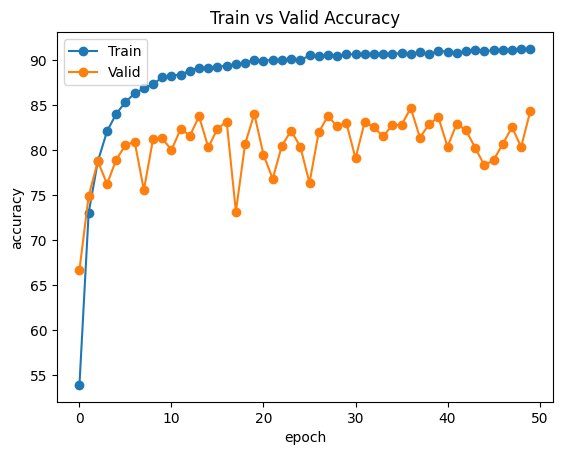

In [13]:
import matplotlib.pyplot as plt

#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

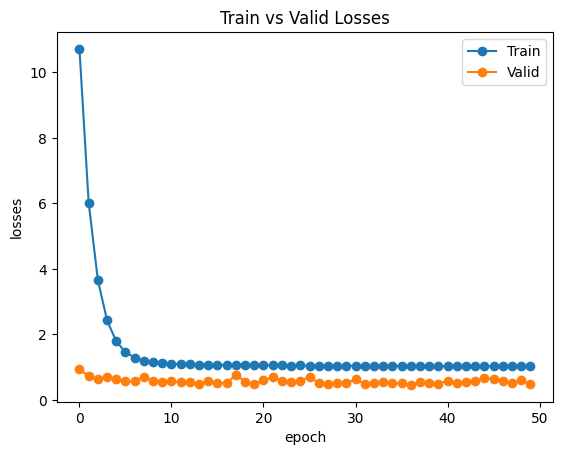

In [14]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [15]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:03<00:00, 80.42it/s]


In [16]:
print(y_pred)
print(y_true)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 3, 9, 5, 7, 9, 8, 5, 7, 8, 6, 9, 0, 0, 9, 4, 3, 4, 0, 9, 6, 6, 5, 4, 5, 9, 8, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 2, 3, 8, 8, 7, 7, 5, 3, 7, 5, 6, 3, 6, 2, 8, 2, 3, 7, 2, 6, 8, 8, 9, 2, 9, 3, 3, 8, 8, 9, 1, 7, 2, 7, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 6, 7, 8, 5, 1, 2, 8, 9, 8, 3, 3, 2, 6, 1, 8, 9, 1, 2, 9, 7, 3, 1, 6, 5, 6, 7, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 3, 4, 2, 1, 6, 6, 8, 2, 8, 4, 5, 8, 9, 9, 9, 8, 9, 9, 3, 7, 3, 9, 0, 5, 2, 2, 3, 8, 6, 3, 3, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 3, 5, 9, 8, 0, 7, 9, 8, 2, 7, 3, 9, 4, 4, 9, 1, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 9, 3, 3, 1, 1, 8, 9, 0, 3, 1, 8, 2, 0, 5, 3, 9, 9, 2, 3, 3, 0, 8, 9, 8, 1, 5, 3, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 3, 0, 7, 4, 3, 9, 1, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 9, 2, 9, 4, 8, 6, 0, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 5, 4, 1, 7, 3, 4, 6, 1, 9, 3, 

In [17]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [18]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [19]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,821,11,23,24,7,1,8,6,56,43
automobile,9,901,1,0,1,3,3,1,16,65
bird,42,1,738,62,36,33,59,19,6,4
cat,15,3,31,778,17,72,44,21,10,9
deer,8,1,32,58,815,17,32,34,3,0
dog,4,2,23,136,15,754,16,42,2,6
frog,4,1,8,44,10,8,918,2,3,2
horse,3,0,15,34,21,22,6,880,2,17
ship,38,12,2,4,1,3,6,0,906,28
truck,11,34,0,7,0,1,9,2,8,928


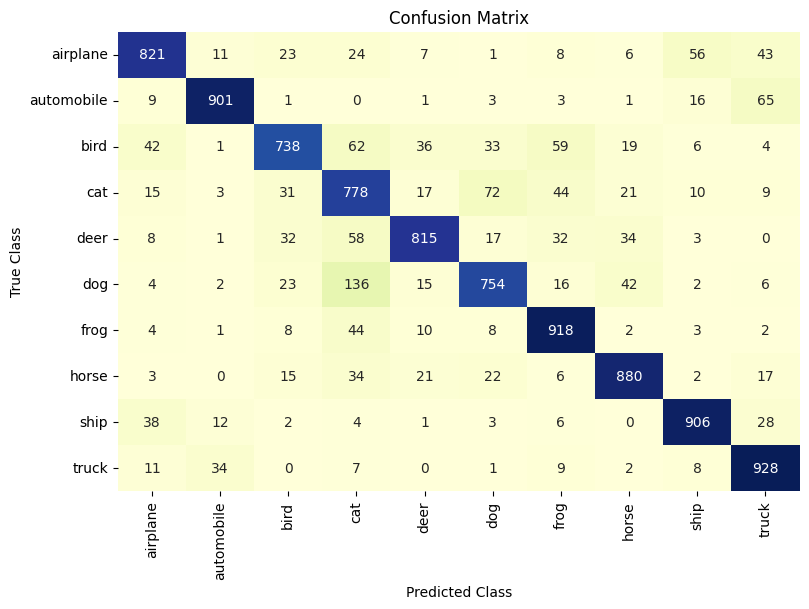

In [20]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

## Train the network (L2-norm with 3e-1 regularization coefficients)

In [23]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    # The following code will be called asynchronously,
    # such that the kernel will be launched and returns control 
    # to the CPU thread before the kernel has actually begun executing
    # has to wait for data to be pushed onto device (synch point)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters()) # L2 regularization
    loss = loss + l2_lambda * l2_norm

    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [24]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [26]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:33<00:00, 46.26it/s]


Train Loss: 0.359 | Accuracy: 90.962


100%|██████████| 313/313 [00:03<00:00, 84.32it/s]


Test Loss: 0.533 | Accuracy: 83.000

Epoch : 2


100%|██████████| 1563/1563 [00:31<00:00, 49.23it/s]


Train Loss: 0.300 | Accuracy: 93.836


100%|██████████| 313/313 [00:03<00:00, 84.67it/s]


Test Loss: 0.568 | Accuracy: 82.540

Epoch : 3


100%|██████████| 1563/1563 [00:31<00:00, 49.86it/s]


Train Loss: 0.259 | Accuracy: 95.586


100%|██████████| 313/313 [00:04<00:00, 66.55it/s]


Test Loss: 0.519 | Accuracy: 84.610

Epoch : 4


100%|██████████| 1563/1563 [00:29<00:00, 52.32it/s]


Train Loss: 0.235 | Accuracy: 96.822


100%|██████████| 313/313 [00:03<00:00, 85.57it/s]


Test Loss: 0.544 | Accuracy: 84.580

Epoch : 5


100%|██████████| 1563/1563 [00:36<00:00, 43.20it/s]


Train Loss: 0.217 | Accuracy: 97.680


100%|██████████| 313/313 [00:03<00:00, 83.10it/s]


Test Loss: 0.526 | Accuracy: 85.020

Epoch : 6


100%|██████████| 1563/1563 [00:32<00:00, 48.32it/s]


Train Loss: 0.211 | Accuracy: 98.128


100%|██████████| 313/313 [00:03<00:00, 80.01it/s]


Test Loss: 0.544 | Accuracy: 85.260

Epoch : 7


100%|██████████| 1563/1563 [00:32<00:00, 48.26it/s]


Train Loss: 0.196 | Accuracy: 98.822


100%|██████████| 313/313 [00:04<00:00, 67.01it/s]


Test Loss: 0.540 | Accuracy: 86.120

Epoch : 8


100%|██████████| 1563/1563 [00:31<00:00, 49.88it/s]


Train Loss: 0.187 | Accuracy: 99.146


100%|██████████| 313/313 [00:05<00:00, 61.32it/s]


Test Loss: 0.545 | Accuracy: 85.820

Epoch : 9


100%|██████████| 1563/1563 [00:30<00:00, 50.57it/s]


Train Loss: 0.178 | Accuracy: 99.420


100%|██████████| 313/313 [00:03<00:00, 80.07it/s]


Test Loss: 0.538 | Accuracy: 85.980

Epoch : 10


100%|██████████| 1563/1563 [00:33<00:00, 46.72it/s]


Train Loss: 0.175 | Accuracy: 99.406


100%|██████████| 313/313 [00:03<00:00, 82.49it/s]


Test Loss: 0.499 | Accuracy: 86.710

Epoch : 11


100%|██████████| 1563/1563 [00:31<00:00, 49.99it/s]


Train Loss: 0.167 | Accuracy: 99.674


100%|██████████| 313/313 [00:05<00:00, 61.35it/s]


Test Loss: 0.472 | Accuracy: 87.500

Epoch : 12


100%|██████████| 1563/1563 [00:31<00:00, 49.69it/s]


Train Loss: 0.155 | Accuracy: 99.890


100%|██████████| 313/313 [00:04<00:00, 75.93it/s]


Test Loss: 0.459 | Accuracy: 87.700

Epoch : 13


100%|██████████| 1563/1563 [00:32<00:00, 48.78it/s]


Train Loss: 0.144 | Accuracy: 99.990


100%|██████████| 313/313 [00:03<00:00, 80.71it/s]


Test Loss: 0.413 | Accuracy: 88.550

Epoch : 14


100%|██████████| 1563/1563 [00:33<00:00, 47.20it/s]


Train Loss: 0.137 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 80.89it/s]


Test Loss: 0.401 | Accuracy: 88.680

Epoch : 15


100%|██████████| 1563/1563 [00:31<00:00, 49.56it/s]


Train Loss: 0.131 | Accuracy: 100.000


100%|██████████| 313/313 [00:05<00:00, 61.21it/s]


Test Loss: 0.386 | Accuracy: 88.850

Epoch : 16


100%|██████████| 1563/1563 [00:31<00:00, 49.81it/s]


Train Loss: 0.126 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 74.61it/s]


Test Loss: 0.379 | Accuracy: 89.050

Epoch : 17


100%|██████████| 1563/1563 [00:31<00:00, 49.23it/s]


Train Loss: 0.121 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 79.71it/s]


Test Loss: 0.377 | Accuracy: 88.910

Epoch : 18


100%|██████████| 1563/1563 [00:32<00:00, 47.63it/s]


Train Loss: 0.116 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 77.32it/s]


Test Loss: 0.373 | Accuracy: 88.960

Epoch : 19


100%|██████████| 1563/1563 [00:32<00:00, 47.54it/s]


Train Loss: 0.112 | Accuracy: 100.000


100%|██████████| 313/313 [00:05<00:00, 61.97it/s]


Test Loss: 0.371 | Accuracy: 88.880

Epoch : 20


100%|██████████| 1563/1563 [00:30<00:00, 50.53it/s]


Train Loss: 0.108 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 81.53it/s]


Test Loss: 0.368 | Accuracy: 89.040

Epoch : 21


100%|██████████| 1563/1563 [00:32<00:00, 48.83it/s]


Train Loss: 0.105 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 83.03it/s]


Test Loss: 0.366 | Accuracy: 88.860

Epoch : 22


100%|██████████| 1563/1563 [00:30<00:00, 50.79it/s]


Train Loss: 0.102 | Accuracy: 100.000


100%|██████████| 313/313 [00:05<00:00, 61.63it/s]


Test Loss: 0.366 | Accuracy: 89.020

Epoch : 23


100%|██████████| 1563/1563 [00:31<00:00, 49.35it/s]


Train Loss: 0.099 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 82.72it/s]


Test Loss: 0.370 | Accuracy: 88.910

Epoch : 24


100%|██████████| 1563/1563 [00:32<00:00, 48.65it/s]


Train Loss: 0.096 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 80.01it/s]


Test Loss: 0.371 | Accuracy: 88.810

Epoch : 25


100%|██████████| 1563/1563 [00:32<00:00, 48.47it/s]


Train Loss: 0.094 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 71.44it/s]


Test Loss: 0.366 | Accuracy: 89.020

Epoch : 26


100%|██████████| 1563/1563 [00:31<00:00, 49.59it/s]


Train Loss: 0.092 | Accuracy: 100.000


100%|██████████| 313/313 [00:05<00:00, 61.05it/s]


Test Loss: 0.371 | Accuracy: 88.710

Epoch : 27


100%|██████████| 1563/1563 [00:31<00:00, 49.68it/s]


Train Loss: 0.090 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 79.95it/s]


Test Loss: 0.373 | Accuracy: 88.680

Epoch : 28


100%|██████████| 1563/1563 [00:33<00:00, 46.05it/s]


Train Loss: 0.088 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 76.11it/s]


Test Loss: 0.375 | Accuracy: 88.780

Epoch : 29


100%|██████████| 1563/1563 [00:32<00:00, 47.45it/s]


Train Loss: 0.086 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 78.24it/s]


Test Loss: 0.373 | Accuracy: 88.610

Epoch : 30


100%|██████████| 1563/1563 [00:31<00:00, 49.54it/s]


Train Loss: 0.084 | Accuracy: 100.000


100%|██████████| 313/313 [00:05<00:00, 60.32it/s]


Test Loss: 0.374 | Accuracy: 88.780

Epoch : 31


100%|██████████| 1563/1563 [00:31<00:00, 49.26it/s]


Train Loss: 0.342 | Accuracy: 91.576


100%|██████████| 313/313 [00:04<00:00, 69.32it/s]


Test Loss: 0.579 | Accuracy: 81.310

Epoch : 32


100%|██████████| 1563/1563 [00:33<00:00, 46.25it/s]


Train Loss: 0.330 | Accuracy: 93.038


100%|██████████| 313/313 [00:03<00:00, 79.59it/s]


Test Loss: 0.516 | Accuracy: 83.790

Epoch : 33


100%|██████████| 1563/1563 [00:32<00:00, 47.60it/s]


Train Loss: 0.256 | Accuracy: 96.176


100%|██████████| 313/313 [00:03<00:00, 79.42it/s]


Test Loss: 0.534 | Accuracy: 84.110

Epoch : 34


100%|██████████| 1563/1563 [00:32<00:00, 48.32it/s]


Train Loss: 0.243 | Accuracy: 97.000


100%|██████████| 313/313 [00:04<00:00, 74.25it/s]


Test Loss: 0.566 | Accuracy: 83.770

Epoch : 35


100%|██████████| 1563/1563 [00:31<00:00, 49.61it/s]


Train Loss: 0.226 | Accuracy: 97.904


100%|██████████| 313/313 [00:05<00:00, 61.13it/s]


Test Loss: 0.528 | Accuracy: 85.890

Epoch : 36


100%|██████████| 1563/1563 [00:31<00:00, 49.77it/s]


Train Loss: 0.202 | Accuracy: 98.850


100%|██████████| 313/313 [00:03<00:00, 79.30it/s]


Test Loss: 0.543 | Accuracy: 85.710

Epoch : 37


100%|██████████| 1563/1563 [00:33<00:00, 46.07it/s]


Train Loss: 0.192 | Accuracy: 99.170


100%|██████████| 313/313 [00:03<00:00, 79.13it/s]


Test Loss: 0.532 | Accuracy: 86.140

Epoch : 38


100%|██████████| 1563/1563 [00:32<00:00, 47.70it/s]


Train Loss: 0.192 | Accuracy: 99.126


100%|██████████| 313/313 [00:03<00:00, 78.97it/s]


Test Loss: 0.544 | Accuracy: 85.680

Epoch : 39


100%|██████████| 1563/1563 [00:31<00:00, 49.44it/s]


Train Loss: 0.176 | Accuracy: 99.702


100%|██████████| 313/313 [00:04<00:00, 65.78it/s]


Test Loss: 0.511 | Accuracy: 86.960

Epoch : 40


100%|██████████| 1563/1563 [00:31<00:00, 49.68it/s]


Train Loss: 0.164 | Accuracy: 99.884


100%|██████████| 313/313 [00:05<00:00, 62.56it/s]


Test Loss: 0.469 | Accuracy: 87.840

Epoch : 41


100%|██████████| 1563/1563 [00:31<00:00, 49.69it/s]


Train Loss: 0.152 | Accuracy: 99.990


100%|██████████| 313/313 [00:03<00:00, 80.23it/s]


Test Loss: 0.427 | Accuracy: 88.320

Epoch : 42


100%|██████████| 1563/1563 [00:32<00:00, 47.88it/s]


Train Loss: 0.144 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 78.83it/s]


Test Loss: 0.406 | Accuracy: 88.660

Epoch : 43


100%|██████████| 1563/1563 [00:32<00:00, 48.76it/s]


Train Loss: 0.137 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 67.81it/s]


Test Loss: 0.397 | Accuracy: 88.640

Epoch : 44


100%|██████████| 1563/1563 [00:31<00:00, 49.82it/s]


Train Loss: 0.131 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 64.13it/s]


Test Loss: 0.394 | Accuracy: 88.640

Epoch : 45


100%|██████████| 1563/1563 [00:31<00:00, 48.88it/s]


Train Loss: 0.126 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 79.55it/s]


Test Loss: 0.381 | Accuracy: 88.810

Epoch : 46


100%|██████████| 1563/1563 [00:33<00:00, 46.14it/s]


Train Loss: 0.121 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 80.59it/s]


Test Loss: 0.379 | Accuracy: 88.730

Epoch : 47


100%|██████████| 1563/1563 [00:31<00:00, 49.14it/s]


Train Loss: 0.117 | Accuracy: 100.000


100%|██████████| 313/313 [00:04<00:00, 74.18it/s]


Test Loss: 0.377 | Accuracy: 88.840

Epoch : 48


100%|██████████| 1563/1563 [00:31<00:00, 50.15it/s]


Train Loss: 0.112 | Accuracy: 100.000


100%|██████████| 313/313 [00:05<00:00, 62.56it/s]


Test Loss: 0.370 | Accuracy: 89.090

Epoch : 49


100%|██████████| 1563/1563 [00:31<00:00, 49.40it/s]


Train Loss: 0.109 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 80.30it/s]


Test Loss: 0.372 | Accuracy: 88.910

Epoch : 50


100%|██████████| 1563/1563 [00:33<00:00, 46.03it/s]


Train Loss: 0.105 | Accuracy: 100.000


100%|██████████| 313/313 [00:03<00:00, 81.21it/s]

Test Loss: 0.371 | Accuracy: 88.800


## Drowing plots

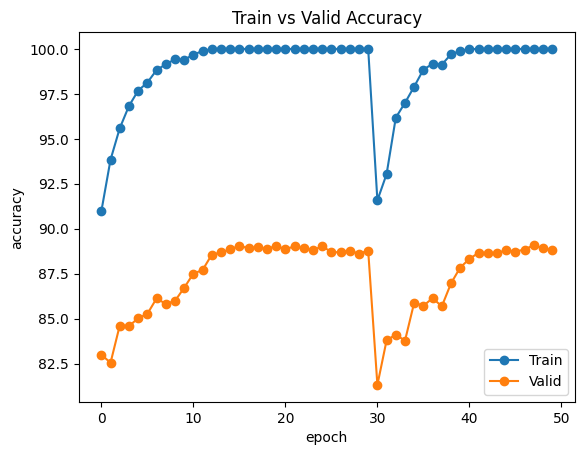

In [27]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

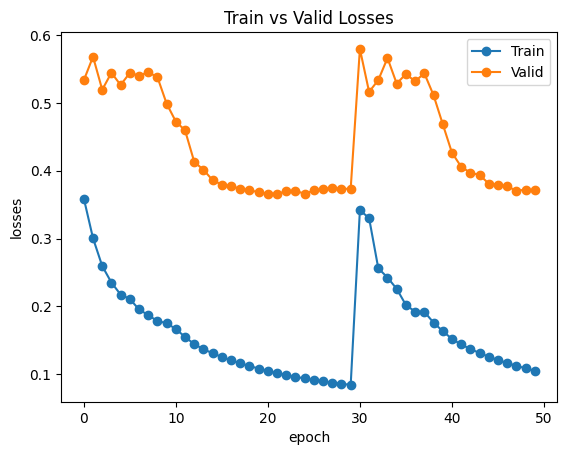

In [28]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [29]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:04<00:00, 75.15it/s]


In [30]:
print(y_pred)
print(y_true)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 8, 5, 9, 2, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 3, 5, 8, 8, 7, 7, 5, 3, 7, 5, 6, 0, 6, 2, 1, 2, 5, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 6, 7, 8, 3, 1, 2, 8, 0, 8, 3, 3, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 8, 6, 5, 6, 3, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 2, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 3, 3, 8, 6, 3, 3, 0, 5, 8, 0, 1, 7, 7, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 4, 9, 5, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 7, 3, 5, 1, 1, 8, 9, 0, 3, 1, 8, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 8, 9, 8, 1, 5, 3, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 3, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 9, 2, 9, 4, 8, 6, 8, 5, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 

In [31]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [32]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [33]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,901,3,25,13,12,1,0,4,32,9
automobile,8,935,0,1,1,2,4,1,13,35
bird,32,0,818,37,34,28,28,18,4,1
cat,14,2,29,781,31,92,27,11,8,5
deer,2,0,29,29,895,10,14,15,6,0
dog,5,1,23,73,25,841,12,18,1,1
frog,3,1,24,19,11,11,928,1,2,0
horse,7,0,13,14,24,26,1,912,1,2
ship,29,9,5,3,0,0,3,1,937,13
truck,13,28,0,1,1,0,7,1,17,932


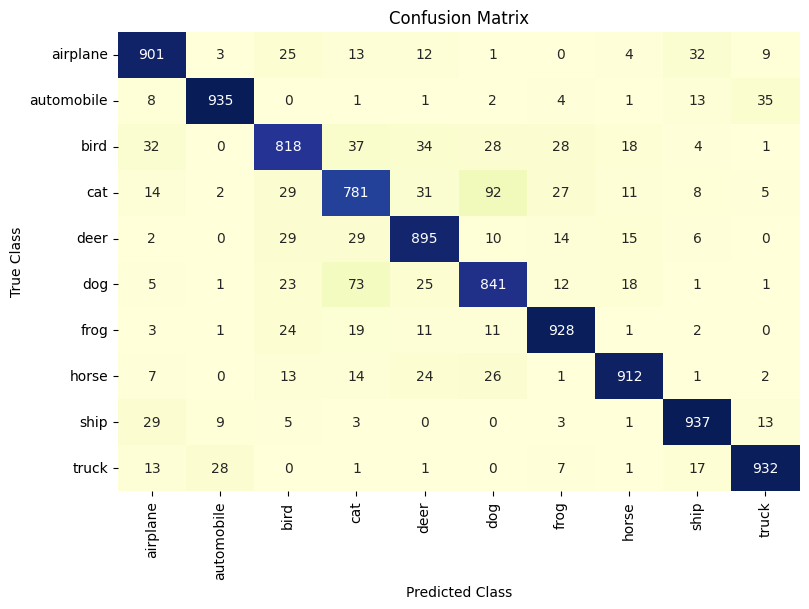

In [34]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()